In [83]:
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from konlpy.tag import Kkma
from pykospacing import Spacing
from gensim.models import Word2Vec

from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [158]:
df = pd.read_excel(r'..\..\..\data\bitcoin_news1.xlsx')
df = df[['cleaned', 'Outcome']]
# 클래스별로 데이터 분리
df_positive = df[df['Outcome'] == '호재']
df_negative = df[df['Outcome'] == '악재']

# 최소 클래스의 샘플 수 확인
min_class_count = min(len(df_positive), len(df_negative))

# 다운샘플링 적용
df_positive_downsampled = resample(df_positive, 
                                   replace=True,                                # 샘플을 복원하지 않고
                                   n_samples=int(min_class_count*1.505),         # 최소 클래스의 개수로 맞추기
                                   random_state=42)                             # 재현성을 위해 random_state 사용

df_negative_downsampled = resample(df_negative, 
                                   replace=True, 
                                   n_samples=int(min_class_count*1.5), 
                                   random_state=42)

df_balanced = pd.concat([df_positive_downsampled, df_negative_downsampled])     # 다운샘플링된 데이터 결합
df = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)         # 데이터 셔플
print(df_balanced['Outcome'].value_counts())                                    # 결과 확인

호재    3794
악재    3781
Name: Outcome, dtype: int64


In [159]:
model = Word2Vec(df['cleaned'], vector_size=100, window=5, min_count=1, workers=4, sg=1)

# 각 단어의 벡터를 데이터프레임에 추가하는 함수
def text_to_vector(text, model):
    words = text.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(model.vector_size)


# 데이터프레임에 feature_vector 열 추가
df['vector'] = df['cleaned'].apply(lambda x: text_to_vector(x, model))

In [160]:
# Word2Vec 모델 학습 (이미 학습된 모델이 있다면 이를 로드하여 사용 가능)
sentences = [sentence.split() for sentence in df['cleaned']]  # 문장을 단어로 분리하여 리스트로 만듦
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

In [161]:
X = np.array(df['vector'].tolist())
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 랜덤 포레스트 모델 초기화 및 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [162]:
# 테스트 데이터에 대한 예측
y_pred = model.predict(X_test)

# 성능 평가
print("Accuracy:", accuracy_score(y_test, y_pred))
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df.style.format("{:.2f}").background_gradient(cmap='Blues')

Accuracy: 0.49438943894389437


c:\Anaconda3\envs\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda3\envs\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda3\envs\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
악재,0.00,0.00,0.00,766.00
호재,0.49,1.00,0.66,749.00
accuracy,0.49,0.49,0.49,0.49
macro avg,0.25,0.50,0.33,1515.00
weighted avg,0.24,0.49,0.33,1515.00


In [163]:
# 하이퍼파라미터 그리드 설정
n_estimators_list = [50, 100]  # 기본 트리 개수 감소
max_depth_list = [5]  # 최대 깊이 제한
min_samples_split_list = [10, 20]  # 분할할 샘플 수 증가
min_samples_leaf_list = [5, 10]  # 리프 노드의 최소 샘플 수 증가
best_score = 0
best_params = {}

# 하이퍼파라미터를 조합하여 모델을 학습
for n_estimators in tqdm(n_estimators_list):
    for max_depth in tqdm(max_depth_list, leave=False):
        for min_samples_split in min_samples_split_list:
            for min_samples_leaf in min_samples_leaf_list:
                # 모델 초기화 및 학습
                model = RandomForestClassifier(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    min_samples_leaf=min_samples_leaf,
                    random_state=42
                )
                model.fit(X_train, y_train)
                
                # 검증 데이터로 성능 평가
                y_pred = model.predict(X_test)
                score = accuracy_score(y_test, y_pred)
                
                # 최적의 모델 저장
                if score > best_score:
                    best_score = score
                    best_params = {
                        'n_estimators': n_estimators,
                        'max_depth': max_depth,
                        'min_samples_split': min_samples_split,
                        'min_samples_leaf': min_samples_leaf
                    }

# 최적의 파라미터 출력
print(f"Best Score: {best_score}")
print(f"Best Parameters: {best_params}")


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]

Best Score: 0.49438943894389437
Best Parameters: {'n_estimators': 50, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 5}


In [164]:
# 최적의 파라미터와 최적 점수 출력
print("Best Score:", best_score)
print("Best Parameters:", best_params)

# 최적의 파라미터로 모델 초기화
best_model = RandomForestClassifier(**best_params, random_state=42)

# 최종 모델 학습
best_model.fit(X_train, y_train)

# 테스트 데이터 예측
y_pred = best_model.predict(X_test)

# 최종 정확도 출력
print("Final Accuracy:", accuracy_score(y_test, y_pred))

# 분류 보고서 출력 및 데이터프레임으로 변환
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# 보고서를 형식화하여 출력
report_df.style.format("{:.2f}").background_gradient(cmap='Blues')

Best Score: 0.49438943894389437
Best Parameters: {'n_estimators': 50, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 5}
Final Accuracy: 0.49438943894389437


c:\Anaconda3\envs\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda3\envs\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda3\envs\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
악재,0.00,0.00,0.00,766.00
호재,0.49,1.00,0.66,749.00
accuracy,0.49,0.49,0.49,0.49
macro avg,0.25,0.50,0.33,1515.00
weighted avg,0.24,0.49,0.33,1515.00


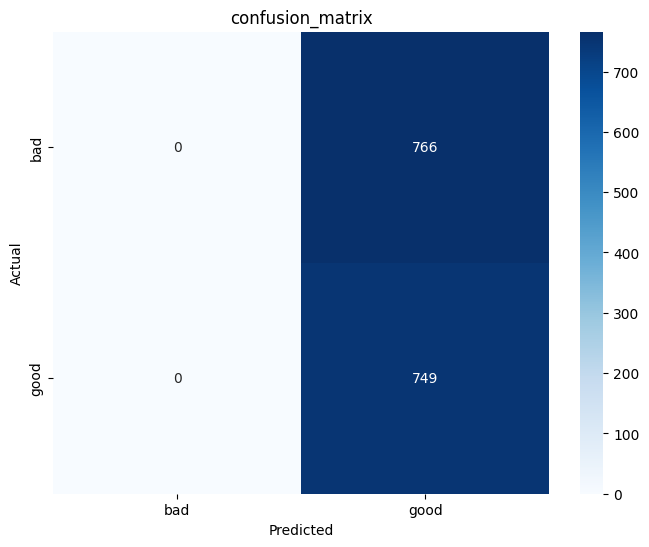

In [165]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['bad', 'good'], yticklabels=['bad', 'good'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('confusion_matrix')
plt.show()

In [166]:
# 새로운 텍스트 데이터 예측
text_to_predict = '''이번 신제품의 성공적인 출시에 따라, 삼성전자의 주가는 연일 상승세를 보이고 있으며, 국내외 투자자들의 관심이 집중되고 있다. 전문가들은 "삼성전자가 이번 신제품을 통해 전 세계 시장에서 더욱 확고한 위치를 다질 것"이라고 전망하고 있다.'''
# 텍스트를 벡터화하여 예측 수행
text_vector = text_to_vector(text_to_predict, word2vec_model).reshape(1, -1)
predicted_outcome = best_model.predict(text_vector)

# 결과 출력
print("Predicted Outcome:", predicted_outcome[0])

Predicted Outcome: 호재
